In [18]:
import os
import sys
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Ajouter manuellement le chemin vers le dossier parent du projet
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from simulation.dispo import simulation_disp
from simulation.demand import simulation_demand
from source import recolte_sang


In [3]:
import gurobipy
print(gurobipy.gurobi.version())


(11, 0, 0)


### Simulation de la disponibilité

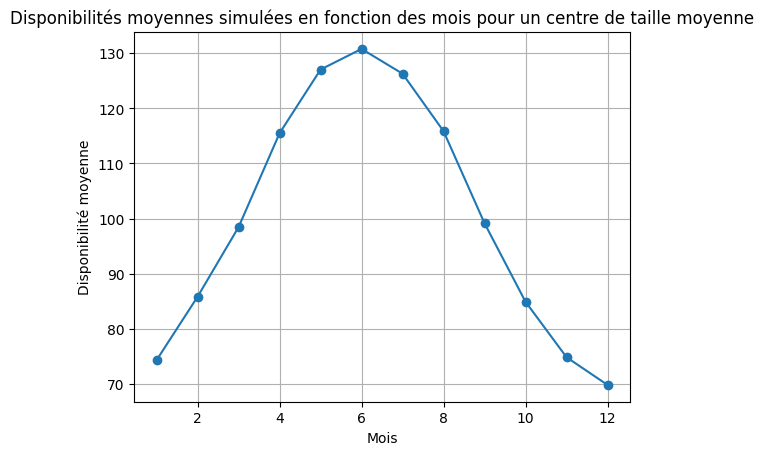

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre de simulations par mois
num_simulations = 500
# Résultats pour chaque mois
r = []

for k in range(1, 13):  # Pour chaque mois
    # Effectuer plusieurs simulations et calculer la moyenne
    disponibilites = [simulation_disp(1, [1], k)[0] for _ in range(num_simulations)]
    r.append(np.mean(disponibilites))  # Moyenne des disponibilités

# Tracer le graphique
plt.plot(range(1, 13), r, marker="o")
plt.xlabel("Mois")
plt.ylabel("Disponibilité moyenne")
plt.title("Disponibilités moyennes simulées en fonction des mois pour un centre de taille moyenne")
plt.grid(True)
plt.show()


### Simulation de la demande de l'hôpital

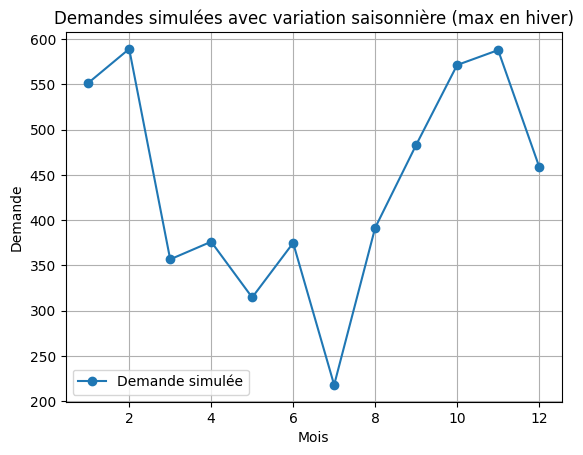

In [21]:
import matplotlib.pyplot as plt

# Paramètres
size = 6  # Taille de l'hôpital (population desservie)
months = range(1, 13)  # Mois de l'année

# Simulations pour chaque mois
demands = [simulation_demand(size, month) for month in months]

# Tracé du graphique
plt.plot(months, demands, marker="o", label="Demande simulée")
plt.xlabel("Mois")
plt.ylabel("Demande")
plt.title("Demandes simulées avec variation saisonnière (max en hiver)")
plt.grid(True)
plt.legend()
plt.show()


## Version déterministe pour une récolte de sang


Solution optimale trouvée :

Camion 1 utilisé :
  Parcours de 0 à 1 avec distance 3.61 0.0
  Parcours de 1 à 4 avec distance 4.47 60.0
  Parcours de 4 à 5 avec distance 4.24 50.0
  Parcours de 5 à 0 avec distance 3.61 20.0
Quantité totale collectée par le camion 1: 130.00

Camion 2 utilisé :
  Parcours de 0 à 3 avec distance 4.12 0.0
  Parcours de 3 à 0 avec distance 4.12 50.0
Quantité totale collectée par le camion 2: 50.00


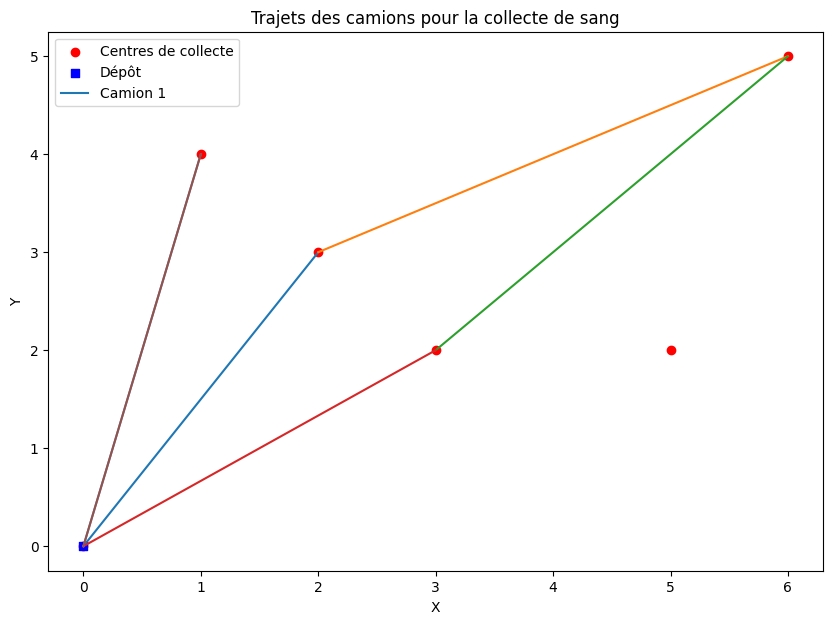

In [17]:


# Définition des ensembles et paramètres
N = 6  # Nombre de centres de collecte (y compris le dépôt)
K = 2 # Nombre de camions disponibles
Q = 170  # Capacité maximale de chaque camion
S_min = 180  # Seuil minimal de stock à collecter
alpha = 1  # Coût fixe par camion déployé

# Coordonnées fictives pour la visualisation
locations = np.array([
    [0, 0],  # Dépôt
    [2, 3],
    [5, 2],
    [1, 4],
    [6, 5],
    [3, 2]
])

# Demandes des centres
dispo = [0, 60, 40, 50, 50,20]  # Le dépôt n'a pas de demande



recolte_sang(N,K,Q,S_min,alpha,locations,dispo)



In [ ]:


# Importer la fonction



r = simulation_disp(5,[1,2,3,4,5],6)

In [12]:
r

array([144.91925258, 227.53507286, 259.85725541, 444.36275786,
       579.51630703])